In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import GridSearchCV

In [39]:
# Load the data
features_df = pd.read_csv('preprocessed_data.csv')
features_names=features_df.columns.tolist()
targets_df = pd.read_csv('data_target.csv')
target_names = targets_df.columns.tolist()
# Combine features and targets
full_df = pd.concat([features_df, targets_df], axis=1)

In [66]:
def prepare_ml_data(features_df, targets_df):
    """Prepare data for multi-label classification"""
    X = features_df.values
    y = targets_df.values
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [67]:
# Prepare machine learning data
X_train, X_test, y_train, y_test = prepare_ml_data(features_df, targets_df)

In [68]:
  
    # XGBoost Classifier with ClassifierChain
    def create_xgboost_classifier_chain():
        # XGBoost base estimator
        xgb_classifier = xgb.XGBClassifier(
            eval_metric='logloss',
            random_state=42
        )
        
        # Wrap with ClassifierChain to capture label dependencies
        classifier_chain = ClassifierChain(
            base_estimator=xgb_classifier, 
            order=None,  # Automatically determine optimal order
            random_state=42
        )
        
        return classifier_chain

In [69]:
# Create and train the model
cc_xgb = create_xgboost_classifier_chain()
cc_xgb.fit(X_train, y_train)
y_pred = cc_xgb.predict(X_test)

In [70]:
def visualize_results(y_true, y_pred, disease_names):
    """
    Comprehensive visualization of machine learning results
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - disease_names: List of disease names
    """
    # 1. Confusion Matrix Visualization
    plt.figure(figsize=(20, 5))
    for i, disease in enumerate(disease_names):
        plt.subplot(1, len(disease_names), i+1)
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No', 'Yes'], 
                    yticklabels=['No', 'Yes'])
        plt.title(f'Confusion Matrix - {disease}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # 2. ROC Curve for Each Disease
    plt.figure(figsize=(20, 5))
    for i, disease in enumerate(disease_names):
        plt.subplot(1, len(disease_names), i+1)
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color='darkorange', 
                 lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {disease}')
        plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # 3. Performance Metrics Bar Plot
    def extract_metrics(y_true, y_pred, disease_names):
        metrics = []
        for i, disease in enumerate(disease_names):
            report = classification_report(y_true[:, i], y_pred[:, i], output_dict=True)
            metrics.append({
                'Disease': disease,
                'Precision': report['weighted avg']['precision'],
                'Recall': report['weighted avg']['recall'],
                'F1-Score': report['weighted avg']['f1-score']
            })
        return pd.DataFrame(metrics)

    metrics_df = extract_metrics(y_true, y_pred, disease_names)
    
    plt.figure(figsize=(12, 6))
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(1, 3, i+1)
        sns.barplot(x='Disease', y=metric, data=metrics_df)
        plt.title(f'{metric} by Disease')
        plt.xticks(rotation=45)
        plt.tight_layout()
    plt.show()





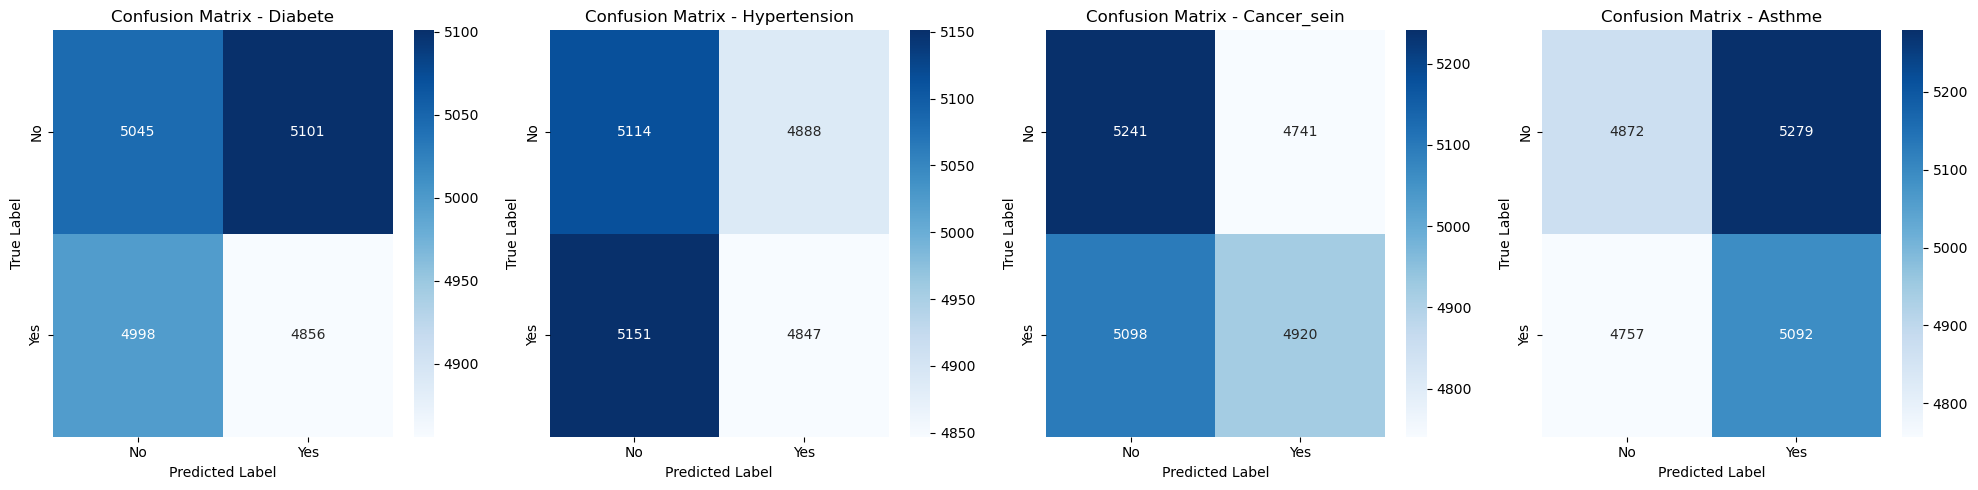

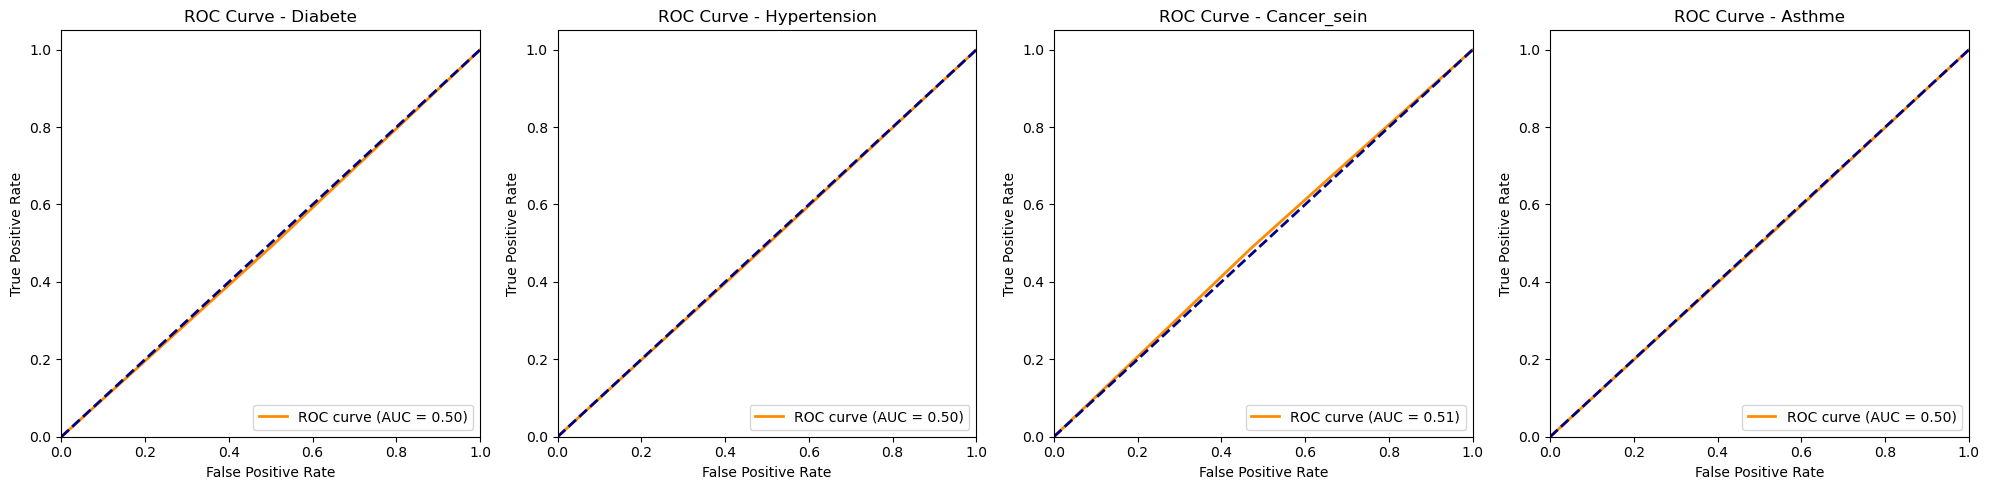

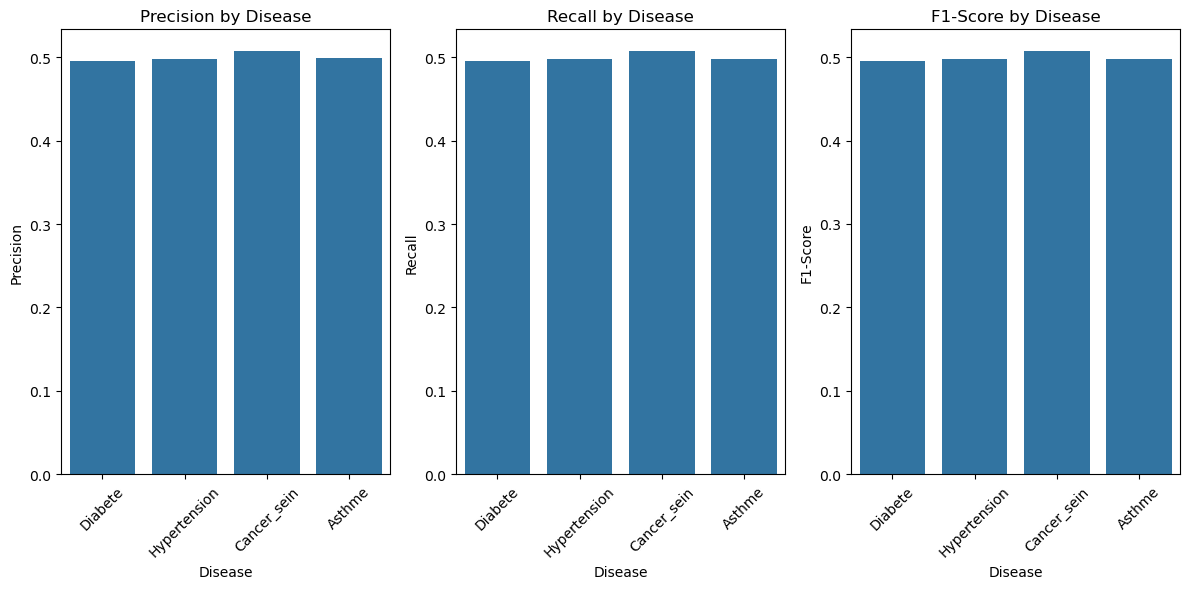

In [71]:
visualize_results(y_test, y_pred,target_names)

# Test With New Data

In [84]:
new_patient = pd.DataFrame([[
    1, 45, 0, 1, 1, 0, 1, 0, 1, 2, 1 
]], columns=features_df.columns)  

In [85]:
new_prediction_porentage = cc_xgb.predict_proba(new_patient.to_numpy())
new_prediction = cc_xgb.predict(new_patient.to_numpy())

In [86]:
new_prediction

array([[1., 0., 1., 0.]])

In [87]:
new_prediction_porentage

array([[0.55316609, 0.2887646 , 0.60394531, 0.38680685]])